In [2]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread

### Oscillator PINN

In [5]:
def exact_solution(d, w0, t):
    '''
    Defines the analytical solution to the under-damped harmonic 
    oscillator problem above.
    '''
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn. Module): 
    '''
    Defines a standard fully-connected network in PyTorch
    '''
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn. Sequential(*[ nn. Sequential(*[ nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [6]:
torch.manual_seed(123)

# Define the output folder for the images
output_folder = os.path.join(os.getcwd(), "images")
os.makedirs(output_folder, exist_ok=True)

# Define list for loss values to be plotted
losses = []

# Define the PINN model
pinn = FCN(1, 1, 32, 3)

# Define boundary points for the boundary loss
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)

# Define training points over the entire domain for the physics loss
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# Define the parameters in the PDE
d, w0 = 2, 20
mu, k = 2*d, w0**2

# Arrays for validating
t_test = torch.linspace(0, 1, 100).view(-1, 1)
u_exact = exact_solution(d, w0, t_test)

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

# Define the number of epochs
num_epochs = 15000

# Train the PINN
for i in range(num_epochs):
    optimizer.zero_grad()

    # Loss coefficients
    lambda1, lambda2 = 1e-1, 1e-4

    # Compute the boundary loss
    u_pred = pinn(t_boundary)
    loss1 = (torch.squeeze(u_pred) - 1)**2
    # boundary_loss = torch.mean((u_pred - 0)**2)

    dudt = torch.autograd.grad(u_pred, t_boundary, torch.ones_like(u_pred), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # Compute the physics loss
    u_pred = pinn(t_physics)

    dudt = torch.autograd.grad(u_pred, t_physics, torch.ones_like(u_pred), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u_pred)**2)

    # Compute the total loss
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        losses.append(loss.item())
        print(f"Epoch {i}: Loss {loss}")
        u = pinn(t_test).detach()
        plt.figure(figsize=(4, 4))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, c='g', alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, c='r', alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact Solution", c='pink')
        plt.plot(t_test[:,0], u[:,0], label="PINN Solution", c='b')
        plt.title(f"Training Step {i}")
        plt.legend()
        
        image_path = os.path.join(output_folder, 
                                  "epoch_{:0{width}d}.png".format(i, width=len(str(num_epochs))))
        plt.savefig(image_path)
        plt.close()

Epoch 0: Loss 1.0218925476074219
Epoch 100: Loss 0.7661262154579163
Epoch 200: Loss 0.7359812259674072
Epoch 300: Loss 0.7013713121414185
Epoch 400: Loss 0.44512879848480225
Epoch 500: Loss 0.18587861955165863
Epoch 600: Loss 0.1528879553079605
Epoch 700: Loss 0.11743609607219696
Epoch 800: Loss 0.08066191524267197
Epoch 900: Loss 0.06065107882022858
Epoch 1000: Loss 0.049521755427122116
Epoch 1100: Loss 0.040381625294685364
Epoch 1200: Loss 0.035431139171123505
Epoch 1300: Loss 0.033625390380620956
Epoch 1400: Loss 0.032558511942625046
Epoch 1500: Loss 0.03179442882537842
Epoch 1600: Loss 0.03069552592933178
Epoch 1700: Loss 0.030698055401444435
Epoch 1800: Loss 0.02836444601416588
Epoch 1900: Loss 0.02977040782570839
Epoch 2000: Loss 0.024662094190716743
Epoch 2100: Loss 0.02371646836400032
Epoch 2200: Loss 0.019304020330309868
Epoch 2300: Loss 0.016757575795054436
Epoch 2400: Loss 0.014690087176859379
Epoch 2500: Loss 0.013762373477220535
Epoch 2600: Loss 0.011877194978296757
Epoch 

In [19]:
import imageio

os.listdir(output_folder)
images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]
imageio.mimsave(os.path.join(os.getcwd(), 'animation.gif'), images, fps=30, duration=0.1, loop=0)

C:\Users\dsash\AppData\Local\Temp\ipykernel_16816\2480283814.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(output_folder, f"{image}")) for image in os.listdir(output_folder) if image.endswith(".png")]


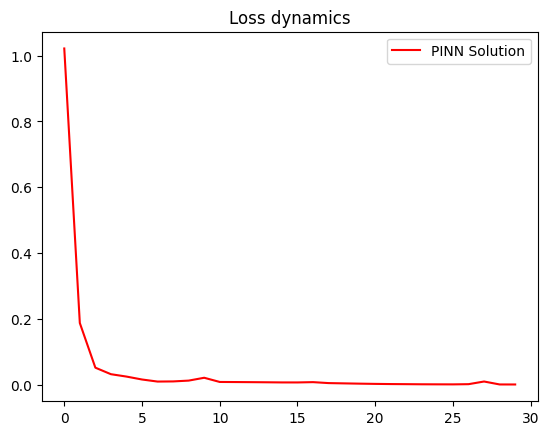

In [20]:
plt.plot(list(range(len(losses))), losses, label="PINN Solution", c='r')
plt.title(f"Loss dynamics")
plt.legend()

### Heat PINN

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation

In [2]:
def visualize_points(x_test, y_test, u_test, norm, title="PINN"):
    # Create a directory to save the images
    save_path="images"
    os.makedirs(save_path, exist_ok=True)

    # Create a figure and axis
    plt.scatter(x_test, y_test, c=u_test, marker='o', cmap='viridis', norm=norm)
    plt.title(title)
    plt.colorbar(label='Temperature')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.axis('equal')

    # Save the plot to the images directory
    plt.savefig(os.path.join(save_path, f'{title}.png'))

    # Show the plot
    plt.show()

In [3]:
def set_boundary_conditions(edge_temps, square_size, num_points_per_edge, T):
    x_boundary_top = np.linspace(0, square_size, num_points_per_edge)
    y_boundary_top = np.ones_like(x_boundary_top) * square_size

    x_boundary_right = np.ones(num_points_per_edge) * square_size
    y_internal_right = np.linspace(0, square_size, num_points_per_edge)

    x_boundary_bottom = np.linspace(square_size, 0, num_points_per_edge)
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros(num_points_per_edge)
    y_boundary_left = np.linspace(square_size, 0, num_points_per_edge)

    x_boundary = np.concatenate([x_boundary_top, x_boundary_right, x_boundary_bottom, x_boundary_left])
    y_boundary = np.concatenate([y_boundary_top, y_internal_right, y_boundary_bottom, y_boundary_left])

    u_boundary = np.zeros_like(x_boundary)

    u_boundary[:num_points_per_edge] = edge_temps[0]  # Top edge
    u_boundary[num_points_per_edge:2*num_points_per_edge] = edge_temps[1]  # Right edge
    u_boundary[2*num_points_per_edge:3*num_points_per_edge] = edge_temps[2]  # Bottom edge
    u_boundary[3*num_points_per_edge:] = edge_temps[3]  # Left edge
    
    t_boundary = np.linspace(0, T, len(x_boundary))

    class BoundaryConditions:
        def __init__(self, x, y, t, u):
            self.x = x
            self.y = y
            self.t = t
            self.u = u

    boundary_conditions = BoundaryConditions(x_boundary, y_boundary, t_boundary, u_boundary)

    return boundary_conditions

In [4]:
def set_initial_conditions(initial_distribution_func, square_size, num_points, random=False):
    # Randomly generate points or make a mesh
    if random:
        x_initial = np.random.uniform(0, square_size, num_points)
        y_initial = np.random.uniform(0, square_size, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_initial = x_grid.flatten()
        y_initial = y_grid.flatten()
    
    t_initial = np.zeros_like(x_initial)
    
    u_initial = initial_distribution_func(x_initial, y_initial)

    class Conditions:
        def __init__(self, x, y, t, u):
            self.x = x
            self.y = y
            self.t = t
            self.u = u

    initial_conditions = Conditions(x_initial, y_initial, t_initial, u_initial)
    
    return initial_conditions

def constant_initial_distribution(x, y):
    return np.ones_like(x) * 2

In [5]:
def set_equation(square_size, num_points, T, random=False):
    if random:
        x_equation = np.random.uniform(0, square_size, num_points)
        y_equation = np.random.uniform(0, square_size, num_points)
        t_equation = np.random.uniform(0, T, num_points)
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_equation = x_grid.flatten()
        y_equation = y_grid.flatten()
        
        t_equation = np.linspace(0, T, len(x_equation))

    class Equation:
        def __init__(self, x, y, t):
            self.x = x
            self.y = y
            self.t = t

    equation = Equation(x_equation, y_equation, t_equation)

    return equation

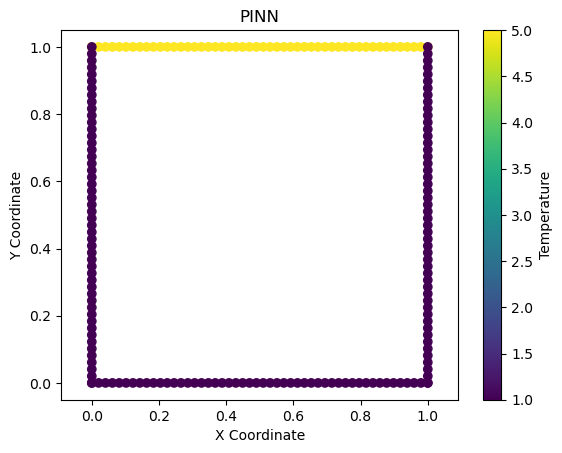

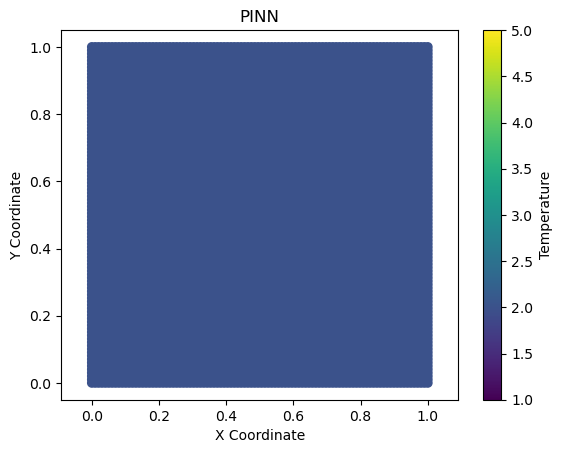

In [10]:
# Set temperatures at the edges [top, right, bottom, left]
edge_temperatures = [5, 1, 1, 1]

# Size of calculation area
square_size = 1.0

# Time of simulation
T = 0.1

# Number of points per edge
num_points_per_edge = 50

# Generate boundary conditions
boundary_conditions = set_boundary_conditions(edge_temperatures, 
                                              square_size, 
                                              num_points_per_edge, 
                                              T)

# Number of points in calculation area
num_points_initial = 100

# Generate initial conditions
initial_conditions = set_initial_conditions(constant_initial_distribution, 
                                            square_size, 
                                            num_points_initial, 
                                            random=False)

# Number of points in equation
num_points_equation = 100

# Generate equation
equation = set_equation(square_size, num_points_equation, T, random=False)

temperature_min = min(np.min(boundary_conditions.u), np.min(initial_conditions.u))
temperature_max = max(np.max(boundary_conditions.u), np.max(initial_conditions.u))
norm = Normalize(vmin=temperature_min, vmax=temperature_max)

visualize_points(boundary_conditions.x, boundary_conditions.y, boundary_conditions.u, norm)
visualize_points(initial_conditions.x, initial_conditions.y, initial_conditions.u, norm)

In [11]:
class PINN():
    def __init__(self, initial_conditions, boundary_conditions, equation):
        # Set data
        self.x_initial = torch.tensor(initial_conditions.x[:, np.newaxis],
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.y_initial = torch.tensor(initial_conditions.y[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.t_initial = torch.tensor(initial_conditions.t[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        self.u_initial = torch.tensor(initial_conditions.u[:, np.newaxis], 
                                      dtype=torch.float32, 
                                      requires_grad=True) # (5000,)
        
        self.x_boundary = torch.tensor(boundary_conditions.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.y_boundary = torch.tensor(boundary_conditions.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.t_boundary = torch.tensor(boundary_conditions.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        self.u_boundary = torch.tensor(boundary_conditions.u[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (200,)
        
        self.x_equation = torch.tensor(equation.x[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)
        self.y_equation = torch.tensor(equation.y[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)
        self.t_equation = torch.tensor(equation.t[:, np.newaxis], 
                                       dtype=torch.float32, 
                                       requires_grad=True) # (10000,)

        # Coefficient of termal conductivity
        self.alpha = 0.1

        # Null vector is needed in equation loss
        self.null = torch.zeros((self.x_equation.shape[0], 1))

        # Initialize network:
        self.network()

        # Optimizer
        self.optimizer = torch.optim.LBFGS(self.net.parameters(), 
                                           lr=1, 
                                           max_iter=500, 
                                           max_eval=50000,
                                           history_size=50, 
                                           tolerance_grad=1e-05, 
                                           tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # Loss function
        self.mse = nn.MSELoss()

        # Loss
        self.loss = 0

        # Iteration number
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1))

    def function(self, x, y, t, is_equation=False):
        u_pred = self.net(torch.hstack((x, y, t)))

        if is_equation:
            dudx = torch.autograd.grad(u_pred, x, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udx2 = torch.autograd.grad(dudx, x, 
                                         grad_outputs=torch.ones_like(dudx), 
                                         create_graph=True)[0]
            dudy = torch.autograd.grad(u_pred, y, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            d2udy2 = torch.autograd.grad(dudy, y, 
                                         grad_outputs=torch.ones_like(dudy), 
                                         create_graph=True)[0]
            dudt = torch.autograd.grad(u_pred, t, 
                                       grad_outputs=torch.ones_like(u_pred), 
                                       create_graph=True)[0]
            return u_pred, dudt, d2udx2, d2udy2

        return u_pred

    def closure(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # Initial loss
        u_prediction = self.function(self.x_initial, self.y_initial, self.t_initial)
        initial_loss = self.mse(u_prediction, self.u_initial)

        # Boundary loss
        u_prediction = self.function(self.x_boundary, self.y_boundary, self.t_boundary)
        boundary_loss = self.mse(u_prediction, self.u_boundary)

        # Equation loss
        _, dudt, d2udx2, d2udy2 = self.function(self.x_equation, self.y_equation, self.t_equation, is_equation=True)
        heat_eq_prediction = dudt - pow(self.alpha, 2) * (d2udx2 + d2udy2)
        equation_loss = self.mse(heat_eq_prediction, self.null)

        self.loss = initial_loss + boundary_loss + equation_loss

        # Derivative with respect to weights
        self.loss.backward()

        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.loss))

        return self.loss

    def train(self):
        # Training loop
        self.net.train()
        self.optimizer.step(self.closure)

In [12]:
# Create model
pinn = PINN(initial_conditions, boundary_conditions, equation)

# Train model
pinn.train()

# Save model
torch.save(pinn.net.state_dict(), 'model.pt')

Iteration: 1, Loss: 9.495816


/usr/lib/python3.11/site-packages/torch/autograd/__init__.py:251: UserWarning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [10000, 1], strides() = [1, 0]
param.sizes() = [10000, 1], strides() = [1, 0] (Triggered internally at /build/python-pytorch/src/pytorch/torch/csrc/autograd/functions/accumulate_grad.h:219.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Iteration: 2, Loss: 8.827770
Iteration: 3, Loss: 4.519738
Iteration: 4, Loss: 5.037529
Iteration: 5, Loss: 2.995789
Iteration: 6, Loss: 2.995527
Iteration: 7, Loss: 2.994413
Iteration: 8, Loss: 2.989853
Iteration: 9, Loss: 2.963641
Iteration: 10, Loss: 3.284847
Iteration: 11, Loss: 2.824686
Iteration: 12, Loss: 2.822506
Iteration: 13, Loss: 2.902770
Iteration: 14, Loss: 2.803983
Iteration: 15, Loss: 211.927155
Iteration: 16, Loss: 10.057944
Iteration: 17, Loss: 2.926823
Iteration: 18, Loss: 2.749278
Iteration: 19, Loss: 2.666720
Iteration: 20, Loss: 2.519882
Iteration: 21, Loss: 2.388078
Iteration: 22, Loss: 2.283408
Iteration: 23, Loss: 2.214911
Iteration: 24, Loss: 2.212885
Iteration: 25, Loss: 2.167174
Iteration: 26, Loss: 2.182625
Iteration: 27, Loss: 2.150012
Iteration: 28, Loss: 2.134586
Iteration: 29, Loss: 2.075683
Iteration: 30, Loss: 2.008495
Iteration: 31, Loss: 1.964837
Iteration: 32, Loss: 1.913159
Iteration: 33, Loss: 1.872398
Iteration: 34, Loss: 1.853297
Iteration: 35, 

In [13]:
def set_test(square_size, num_points, random=False):
    if random:
        x_test = np.random.uniform(0, square_size, num_points)
        y_test = np.random.uniform(0, square_size, num_points)
        t_test = np.ones(num_points) * 0.1
    else:
        x_points = np.linspace(0, square_size, num_points)
        y_points = np.linspace(0, square_size, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_test = x_grid.flatten()
        y_test = y_grid.flatten()

        t_test = np.ones(len(x_test)) * 0.1    

    class Test:
        def __init__(self, x, y, t):
            self.x = x
            self.y = y
            self.t = t

    test = Test(x_test, y_test, t_test)

    return test

In [15]:
pinn = PINN(initial_conditions, boundary_conditions, equation)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()

test = set_test(1, 100)

x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(test.y[:, np.newaxis], dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(test.t[:, np.newaxis], dtype=torch.float32, requires_grad=True)

u = pinn.function(x_test, y_test, t_test)

torch.Size([10000, 1])


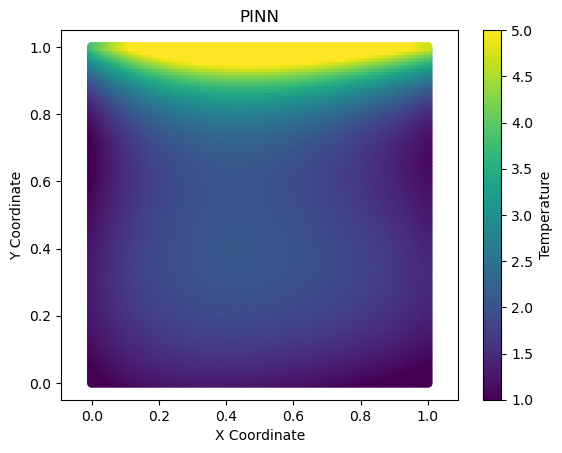

In [16]:
print(u.shape)

visualize_points(test.x, test.y, u.to('cpu').detach().numpy(), norm)

### FDM solver

In [110]:
def set_initial_conditions(initial_temperature, u):
    u[:, :, 0] = initial_temperature
    return u

def set_boundary_conditions(edge_temperatures, u):
    num_points_x, num_points_y, _ = u.shape
    
    # Top edge
    u[num_points_x-1, :, :] = edge_temperatures[0]

    # Right edge
    u[:, num_points_y-1, :] = edge_temperatures[1]

    # Bottom edge
    u[:, 0, :] = edge_temperatures[2]

    # Left edge
    u[0, :, :] = edge_temperatures[3]

    return u

In [134]:
# Coefficient of termal conductivity
alpha = 0.1

# Size of calculation area
square_size = 1.0

# Number of points per edge
num_points = 100

dt = 0.1 # time step
T = 0.1 # final time

# Set temperatures at the edges [top, right, bottom, left] and initial temperature
edge_temperatures = [5, 1, 1, 1]
initial_temperature = 2

# Size of calculation area
square_size = 1.0

# Computes cell length
dx = square_size/num_points;
dy = square_size/num_points;

# Courant number
CFL = 0.1;
dt = CFL * pow(dx, 2) / alpha;

u = np.zeros((num_points,num_points,int(T/dt)))
print("Size of calculation area", u.shape)

u = set_initial_conditions(initial_temperature, u)
u = set_boundary_conditions(edge_temperatures, u)

# Generate 2D mesh
X = np.linspace(0, square_size, num_points, endpoint=True)
Y = np.linspace(0, square_size, num_points, endpoint=True)
X, Y = np.meshgrid(X, Y)

# Main time-loop of explicit method
for t in range(int(T/dt)-1):
    for i in range(1, num_points-1):
        for j in range(1, num_points-1):
            # Computing the right-hand side
            a = (u[i+1, j, t] - 2*u[i, j, t] + u[i-1, j, t]) / pow(dx, 2)  # d2dx2
            b = (u[i, j+1, t] - 2*u[i, j, t] + u[i, j-1, t]) / pow(dy, 2)  # d2dy2
            u[i, j, t+1] = pow(alpha, 2) * dt * (a + b) + u[i, j, t]

Size of calculation area (100, 100, 1000)


In [138]:
def visualize_temperature(u, time_index, norm, title="FDM"):
    # Create a directory to save the images
    save_path="images"

    # Create a figure and axis
    os.makedirs(save_path, exist_ok=True)

    plt.imshow(u[:, :, time_index], cmap='viridis', origin='lower',
               extent=[0, 1, 0, 1], norm=norm)
    
    plt.colorbar(label='Temperature')
    plt.title(f'Temperature Distribution at Time Step {time_index}')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Save the plot to the images directory
    plt.savefig(os.path.join(save_path, f'{title}.png'))

    # Show the plot
    plt.show()

In [139]:
temperature_min = np.min(u)
temperature_max = np.max(u)
print(temperature_min, temperature_max)

1.0 5.0


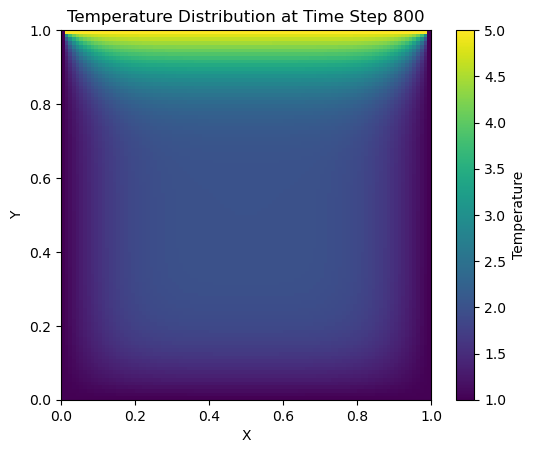

In [140]:
temperature_min = np.min(u)
temperature_max = np.max(u)
norm=Normalize(vmin=temperature_min, vmax=temperature_max)

t_index = 800  # Замените это на желаемый индекс времени

visualize_temperature(u, t_index, norm)

### FEM or FVM solver

In [50]:
# TODO: FEM or FVM solver for 2D heat transfer problem implementation

### Compare methods

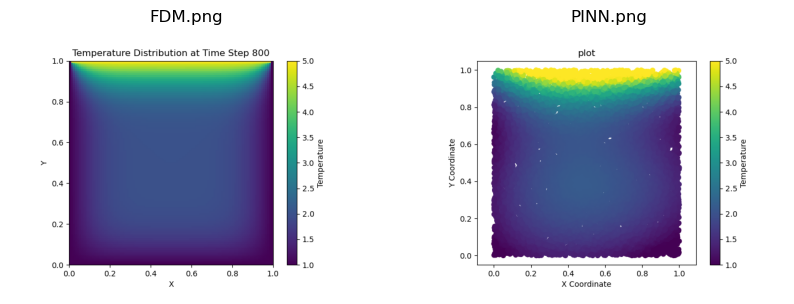

In [144]:
images_folder = "images"
image_files = os.listdir(images_folder)
image_files = [f for f in image_files if f.endswith(".png") and (f.startswith("PINN") or f.startswith("FDM"))]

if len(image_files) == 2:
    image1 = imread(os.path.join(images_folder, image_files[0]))
    image2 = imread(os.path.join(images_folder, image_files[1]))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image1)
    axes[0].set_title(image_files[0])
    axes[0].axis("off")

    axes[1].imshow(image2)
    axes[1].set_title(image_files[1])
    axes[1].axis("off")

    plt.show()

### Analytical solution

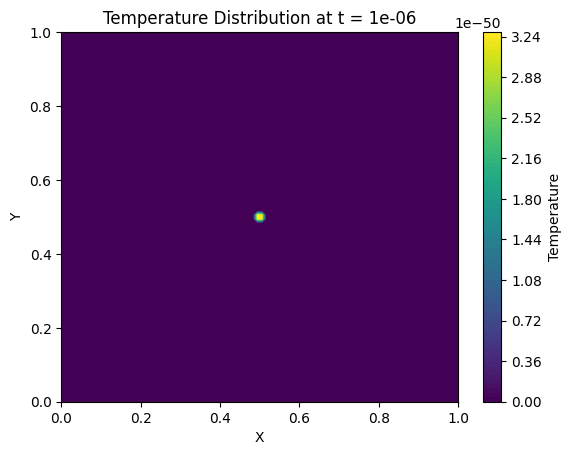

In [5]:
def heat_kernel(x, y, t, x0, y0, alpha=0.1):
    return 1 / (4 * np.pi * alpha * t) * np.exp(-((x - x0)**2 + (y - y0)**2) / (4 * alpha * t))

# Задаем параметры для построения
x_values = np.linspace(0, 1, 100)
y_values = np.linspace(0, 1, 100)
t_value = 0.000001

# Создаем сетку
x, y = np.meshgrid(x_values, y_values)

# Выбираем координаты дельта-функции
x0, y0 = 0.5, 0.5

# Вычисляем функцию Грина для момента времени t
G = heat_kernel(x, y, t_value, x0, y0)

# Строим график контуров
plt.contourf(x, y, G, cmap='viridis', levels=100)
plt.colorbar(label='Temperature')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Temperature Distribution at t = {t_value}')
plt.show()